## Training loop for Binary Classification

### Input data

<Figure size 1000x500 with 0 Axes>

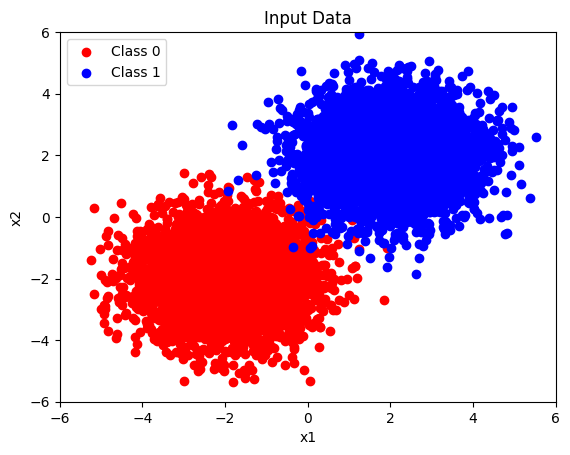

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. Generate 2D Gaussian data
np.random.seed(42)
n_samples = 10000

# Generate standard normal 2D Gaussian data [2 x n_samples]
X = np.random.randn(2, n_samples)

# Shift means
X[:, :n_samples // 2] += np.array([[-2], [-2]])  # First half to mean (-2, -2)
X[:, n_samples // 2:] += np.array([[2], [2]])    # Second half to mean (2, 2)

# Labels: first half -> 0, second half -> 1
y = np.hstack([np.zeros(n_samples // 2), np.ones(n_samples // 2)]).reshape(1, -1)

# Visualization
plt.figure(figsize=(10, 5))

# Input points
plt.figure()
plt.scatter(X[0,:n_samples // 2], X[1,:n_samples // 2], color='red', label='Class 0')
plt.scatter(X[0,n_samples // 2:], X[1,n_samples//2:], color='blue', label='Class 1')

plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(); plt.title("Input Data")
plt.xlim(-6, 6); plt.ylim(-6, 6)
plt.show()



### Training loop

/home/home/anaconda3/envs/graphrag/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


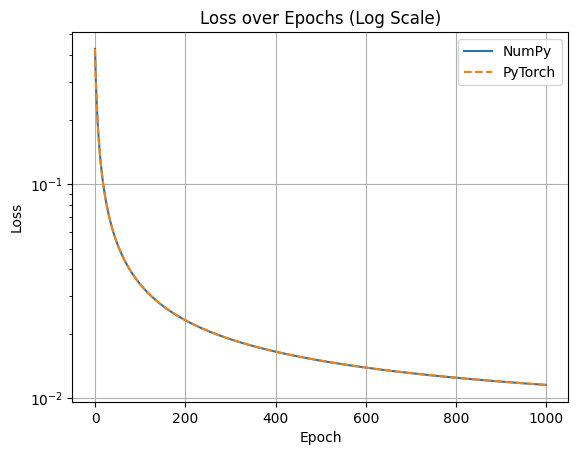


Final Parameters:
NumPy w: [2.07576617 1.93699636], b: -0.0127
PyTorch w: [2.0757656 1.936997 ], b: -0.0127


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# -------------------------
# Shared Initialization
# -------------------------
np.random.seed(42)
w_init = np.random.randn(2, 1)
b_init = 0.0
lr = 0.1
epochs = 1000

# -------------------------
# NumPy version
# -------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward(w, b, X):
    z = w.T @ X + b
    return sigmoid(z)

def compute_loss(a, y):
    eps = 1e-10
    return -np.mean(y * np.log(a + eps) + (1 - y) * np.log(1 - a + eps))

def compute_grads(X, a, y):
    m = X.shape[1]
    dz = a - y
    dw = (X @ dz.T) / m
    db = np.mean(dz)
    return dw, db

# Copy init values
w_np = w_init.copy()
b_np = b_init
loss_np = []

# Training loop
for epoch in range(epochs):
    a = forward(w_np, b_np, X)
    loss = compute_loss(a, y)
    dw, db = compute_grads(X, a, y)
    w_np -= lr * dw
    b_np -= lr * db
    loss_np.append(loss)

# -------------------------
# PyTorch version
# -------------------------
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

# Use same initial values
w_torch = torch.tensor(w_init, dtype=torch.float32, requires_grad=True)
b_torch = torch.tensor(b_init, dtype=torch.float32, requires_grad=True)
loss_torch = []

for epoch in range(epochs):
    z = w_torch.T @ X_torch + b_torch
    a = torch.sigmoid(z)
    eps = 1e-10
    
    # Use PyTorch BCE loss
    loss = F.binary_cross_entropy(a, y_torch)    
    loss_torch.append(loss.item())

    loss.backward()

    with torch.no_grad():
        w_torch -= lr * w_torch.grad
        b_torch -= lr * b_torch.grad

    w_torch.grad.zero_()
    b_torch.grad.zero_()

# -------------------------
# Plotting
# -------------------------
plt.figure()
plt.semilogy(loss_np, label='NumPy')
plt.semilogy(loss_torch, label='PyTorch', linestyle='--')
plt.title("Loss over Epochs (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------
# Print Final Parameters
# -------------------------
print("\nFinal Parameters:")
print(f"NumPy w: {w_np.ravel()}, b: {b_np:.4f}")
print(f"PyTorch w: {w_torch.detach().numpy().ravel()}, b: {b_torch.item():.4f}")


### Results

(-6.0, 6.0)

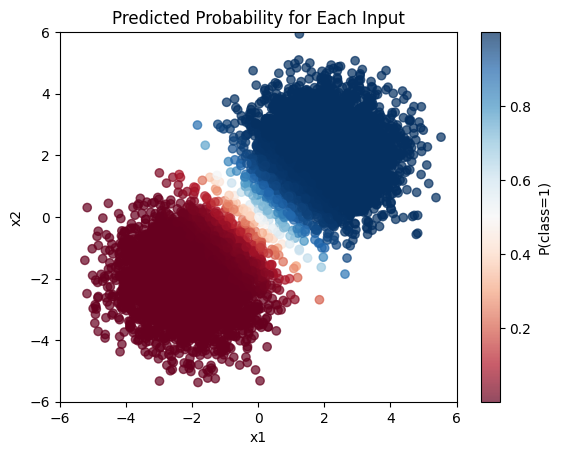

In [3]:
pred_probs = forward(w_np, b_np, X).flatten()  # [2n]

# Inputs, colored by predicted probability
plt.figure()
sc = plt.scatter(X[0], X[1], c=pred_probs, cmap='RdBu', alpha=0.7)
plt.colorbar(sc, label="P(class=1)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Predicted Probability for Each Input")
plt.xlim(-6, 6); plt.ylim(-6, 6)

### Threshold vs Classification error

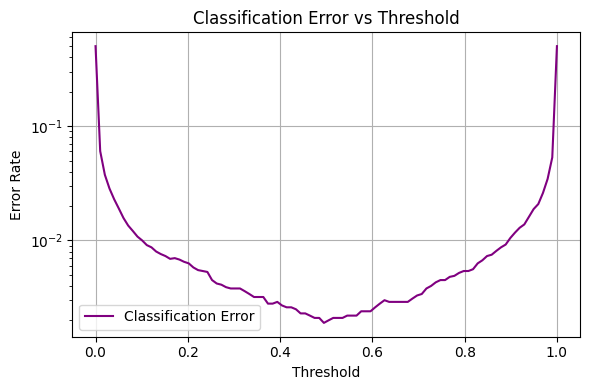

In [4]:
# Threshold sweep and classification error
thresholds = np.linspace(0, 1, 100)
errors = []


for t in thresholds:
    y_pred = (pred_probs >= t).astype(int)  # [2n]
    error = np.mean(y_pred != y.flatten())
    errors.append(error)

# Plot classification error vs threshold
plt.figure(figsize=(6, 4))
plt.semilogy(thresholds, errors, label='Classification Error', color='purple')
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("Classification Error vs Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
